# Creating diagrams from the Kubernetes API

## Using Python, Diagrams and JupyterLab

**Frederico Muñoz**


## Why?

Using text-based formats for documentation makes a lot of things easier, namely the way it aligns with the rest of the toolset used.

* Ability to use all the functionalities of SCM systems: merges, forks, pull requests, history, reversion, etc.
* Easy to automate the production and final output, from PDF documents to HTML pages, all from the same source.
* Integration of scripts and code

For the last point Jupyter notebooks are a common choice (especially for Python); here I demonstrate the use of the official Kubernetes library to produce this prensentation and some very simple diagrams of a Kubernetes cluster with a simple application deployed (using [minikube](https://minikube.sigs.k8s.io/docs/start/))

Above all using this approach allows the creation of up-to-date documentation since the sections that are supposed to reflect what exists are automatically updated: this in turn reduces issues from out-of-date documentation that is always playing catch-up with changes.

## Setting things up

This is straight form the [official Kubernetes client for Python](https://github.com/kubernetes-client/python) documentation; to work `kubectl` should be working correctly in the desired context, e.g. `kubectl config view`should work. 

In [344]:
from kubernetes import client, config
config.load_kube_config()
v1 = client.CoreV1Api()
display(v1)

## Nodes

Let's start by creating a dataframe with some basic information on the nodes.

In [345]:
import collections
import pandas as pd

nodes = v1.list_node(watch=False)
node_list = []
for i in nodes.items:
    node_dict = collections.OrderedDict()
    node_dict["Name"]= i.metadata.name
    node_dict["OS"]= i.status.node_info.operating_system
    node_dict["OS image"]= i.status.node_info.os_image
    node_dict["Runtime"]= i.status.node_info.container_runtime_version
    node_list.append(node_dict)

nodes_df = pd.DataFrame(node_list)
display(nodes_df)

,Name,OS,OS image,Runtime
0,multinode,linux,Buildroot 2020.02.10,docker://20.10.4
1,multinode-m02,linux,Buildroot 2020.02.10,docker://20.10.4


We set up some global attributes to be used later; these specify Graphviz attributes that determine how the graphs looks.

In [346]:
graph_attr = {
    "layout": "fdp",
}
cluster_attr = {
    "fontsize": "12",
    "style": "filled",
    "fillcolor": "grey97"
}
node_attr = {
    "fontsize": "8"   
}

We also do all the imports right away to make the code shorter in later blocks.

In [347]:
from diagrams import Cluster, Diagram
from diagrams.k8s.clusterconfig import HPA
from diagrams.k8s.compute import Deployment, Pod, ReplicaSet
from diagrams.k8s.infra import Node, Master
from diagrams.k8s.network import Ingress, Service
from diagrams.k8s.group import Namespace
from diagrams.k8s.podconfig import Secret

## About Diagrams

[Diagrams](https://diagrams.mingrammer.com/) is the library we will use to produce the diagrams; from the home page:
> Diagrams lets you draw the cloud system architecture in Python code.
> It was born for prototyping a new system architecture without any design tools. You can also describe or visualize the existing system architecture as well.
> Diagram as Code allows you to track the architecture diagram changes in any version control system.


It uses [Graphviz](https://graphviz.org/) to build the graphs so that needs to be installed as well.

## Show the nodes

Using the dataframe and Diagrams we can build this simple cluster diagram by iteractig through the nodes:

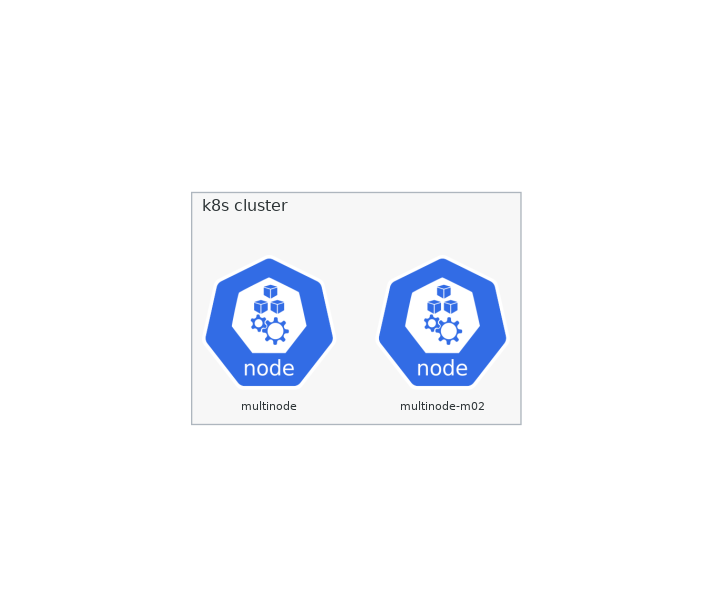

In [357]:
with Diagram(show=False, direction="LR",graph_attr=graph_attr, node_attr=node_attr) as diag:
    with Cluster("k8s cluster", graph_attr=cluster_attr):
        for idx,node in  nodes_df.iterrows():
            Node(node["Name"]) #>> Service("svc")
diag

## Namespaces

The cluster has the following namespaces (or "projects") - again, we process the dict to build a dataframe.

In [358]:
ns = v1.list_namespace(watch=False)
ns_list = []
for i in ns.items:
    ns_dict = collections.OrderedDict()
    ns_dict["Name"]= i.metadata.name
    ns_dict["UID"]= i.metadata.uid
    ns_list.append(ns_dict)
ns_df = pd.DataFrame(ns_list)
display(ns_df)

,Name,UID
0,default,0086019d-bc33-4b04-a4e3-4f63f3472621
1,kube-node-lease,6d7de7e1-02ab-4d70-9e4a-0b9237890f73
2,kube-public,4dd3461e-726c-4595-a3dc-d2bbc0748851
3,kube-system,db61c947-b684-4efc-8c45-9a9ed915852d


We can show the namespaces using a similar approach.

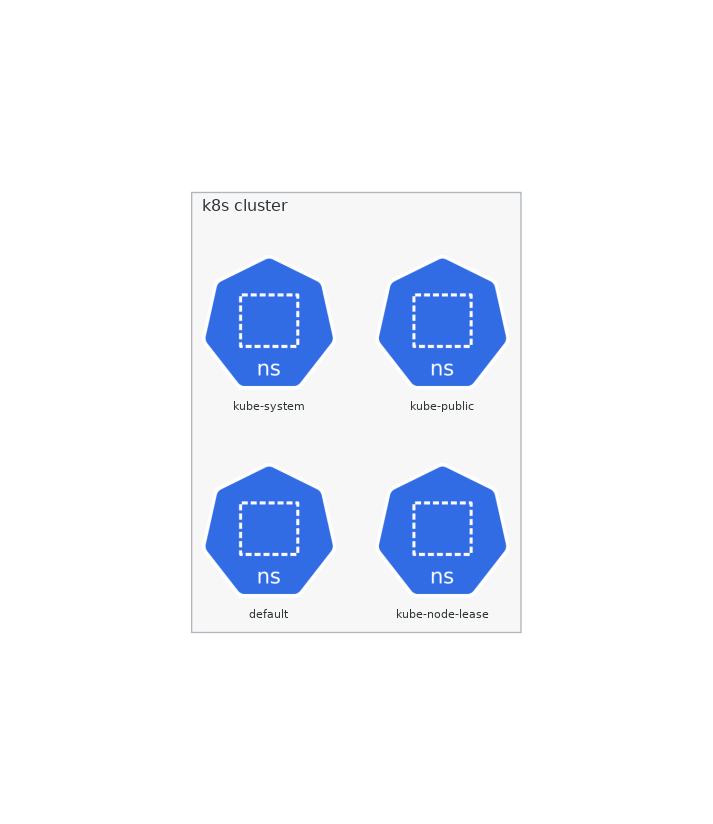

In [359]:
with Diagram(show=False,graph_attr=graph_attr,node_attr=node_attr) as diag:
    with Cluster("k8s cluster", graph_attr=cluster_attr):
        for idx,namespace in ns_df.iterrows():
            Namespace(namespace["Name"])
diag

## Pods

The approach is the same; not that we are building Pandas dataframes because this is useful for other purposes (namely for the production of a PDF via LaTeX), but directly using the `dict` is possible and would actually be simpler. I'm using a simplistic approach for the label/selector pairing, so I simply add an "App" column that contains the label.

In [360]:
ret = v1.list_pod_for_all_namespaces(watch=False)
pods_list = []
for i in ret.items:
    pods_dict = collections.OrderedDict()
    pods_dict["Name"]= i.metadata.name
    pods_dict["Namespace"]= i.metadata.namespace
    pods_dict["IP"] = i.status.pod_ip
    pods_dict["Node"] = i.status.host_ip
    pods_dict["Start"]= i.status.start_time
    if "app" in i.metadata.labels:
        pods_dict["App"] = i.metadata.labels["app"]
    else:
        pods_dict["App"] = ""
    for v in i.spec.volumes:
        if v.secret is not None:
            pods_dict["Secret"] = v.secret.secret_name
        else:
            pods_dict["Secret"] = ""
    pods_list.append(pods_dict)
pods_df = pd.DataFrame(pods_list)
display(pods_df)

,Name,Namespace,IP,Node,Start,App,Secret
0,web-79d88c97d6-qjwrb,default,10.244.1.2,192.168.99.102,2021-04-15 11:08:42+00:00,web,default-token-xcg4s
1,coredns-74ff55c5b-22d2c,kube-system,10.244.0.2,192.168.99.101,2021-04-15 10:56:28+00:00,,coredns-token-mh9wz
2,etcd-multinode,kube-system,192.168.99.101,192.168.99.101,2021-04-15 10:55:54+00:00,,
3,kindnet-h6jqn,kube-system,192.168.99.102,192.168.99.102,2021-04-15 10:56:47+00:00,kindnet,kindnet-token-9f9xk
4,kindnet-n4h8k,kube-system,192.168.99.101,192.168.99.101,2021-04-15 10:56:09+00:00,kindnet,kindnet-token-9f9xk
5,kube-apiserver-multinode,kube-system,192.168.99.101,192.168.99.101,2021-04-15 10:55:54+00:00,,
6,kube-controller-manager-multinode,kube-system,192.168.99.101,192.168.99.101,2021-04-15 10:55:54+00:00,,
7,kube-proxy-n8jz5,kube-system,192.168.99.101,192.168.99.101,2021-04-15 10:56:09+00:00,,kube-proxy-token-brdgp
8,kube-proxy-zlnwn,kube-system,192.168.99.102,192.168.99.102,2021-04-15 10:56:47+00:00,,kube-proxy-token-brdgp
9,kube-scheduler-multinode,kube-system,192.168.99.101,192.168.99.101,2021-04-15 10:55:54+00:00,,


We also get the **Services**, including their selector.

In [361]:
services = v1.list_service_for_all_namespaces(watch=False)
srv_list = []
for i in services.items:
    srv_dict = collections.OrderedDict()
    srv_dict["Name"]= i.metadata.name
    srv_dict["Type"]= i.spec.type
    srv_dict["IP"]= i.spec.cluster_ip
    if i.spec.selector is not None:
        if "app" in i.spec.selector:
            srv_dict["App"] = i.spec.selector["app"]
    srv_list.append(srv_dict)
srv_df = pd.DataFrame(srv_list)
display(srv_df)

,Name,Type,IP,App
0,kubernetes,ClusterIP,10.96.0.1,NaN
1,web,NodePort,10.99.132.93,web
2,kube-dns,ClusterIP,10.96.0.10,NaN


And now we tie it all up: looking to the `default` namespace (which is where I deployed the application) the pod, service and secret - with their relatoinships - are built.

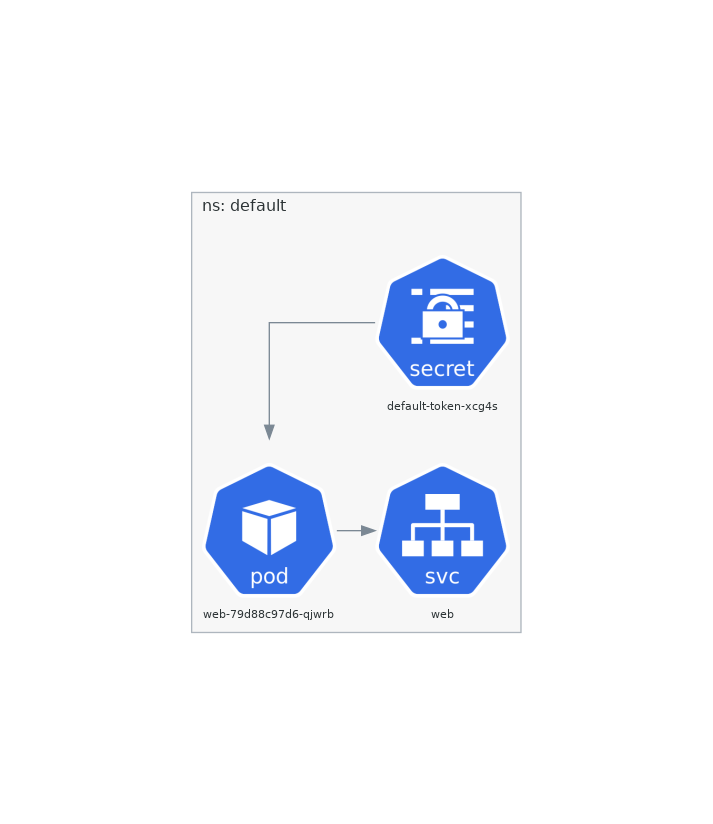

In [362]:
with Diagram(show=False, graph_attr=graph_attr, node_attr=node_attr) as diag:
    with Cluster("ns: default", graph_attr=cluster_attr):
        for idx,pod in pods_df[pods_df["Namespace"] == "default"].iterrows():
            p = Pod(pod["Name"])
            if srv_df[srv_df["App"] == pod["App"]]["Name"].any():
                p >> Service(pod["App"])
            if pod["Secret"]:
                Secret(pod["Secret"]) >> p
diag

## Final words

JupyterLab can export to several different formats, including [AsciiDoc](https://asciidoc.org/), [LaTeX](https://www.latex-project.org/) and obviously [Reveal.js](https://revealjs.com/) that was used to produce this presentation - on top of the HTML export and the ablity to use it interactively.

Since we're in a Jupyter notebook a lot more can be done: using any of the visualisations libraries (like [Seaborn](https://seaborn.pydata.org/)) we can automatically produce plots and statistics about our cluster: this simple example uses`matplotlib` and `Seaborn` to show how many pods are running in each node.

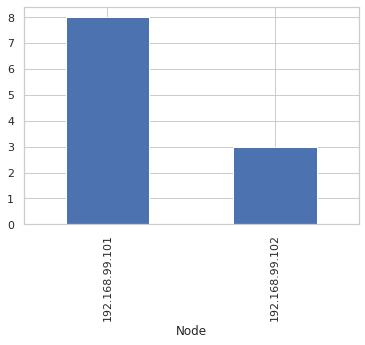

In [363]:
import seaborn as sns
sns.set()
sns.set_style("whitegrid")

pods_df[["Name","Node"]].groupby('Node').count().plot(kind="bar",legend=False)